Import relevant packages

In [1]:
COLAB = False

import sys
import torch.nn.functional as F
import pandas as pd
import numpy as np
import math, random, time
import torch
import torchaudio
from pathlib import Path
from torch import nn
from torch.nn import init
from torchaudio import transforms
from sklearn.model_selection import KFold
from IPython.display import Audio
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler

if 'google.colab' in str(get_ipython()):
    COLAB = True
    print('Running on CoLab')
else:
    COLAB = False
    print('Not running on CoLab')

if COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    base = Path("/content/drive/MyDrive/Colab Notebooks/scratch")
else:
    base = Path("C:/Users/bkweb/Documents/dragn/MusGen/src")
sys.path.append(str(base))

Not running on CoLab


Prepare training data

In [21]:
# # ----------------------------
# # use classified_songs to collect key labels
# # ----------------------------

# Read in the file with song filenames and corresponding labels, and drop duplicates
file = Path(base, 'song_data/classified_songs_V2.csv')
df = pd.read_csv(file, sep='\t')[['Id', 'Key']]
df = df.drop_duplicates(subset=['Id'])

# Create a dictionary mapping filenames to their relative paths
f_to_rp = dict()
data_path = base.joinpath('wav_data_collections')
for root, dirs, files in os.walk(data_path):
    for f in files:
        f_to_rp[Path(f).stem] = Path((root + '\\' + f)[63:])

# Since this is binary classification, replace mode labels with either 1 or 0
mask = df['Key'].str.contains('minor')
df['Key'] = df['Key'].where(mask, other = 1)
df['Key'] = df['Key'].where(~mask, other = 0)

# Re-label columns to match SoundDS expectations
df.rename(columns={'Id': 'relative_path', 'Key': 'classID'}, inplace=True)

# Filter out entries we don't have in .wav format, and add relevant relative_path s to df
mask = df['relative_path'].apply(lambda x: x in f_to_rp.keys())
df = df[mask]
df = df.replace({'relative_path': f_to_rp})
df = df.reset_index(drop=True)

In [3]:
# df=df.sample(25)
# df = df.reset_index(drop=True)

AudioUtil Class

In [23]:
class AudioUtil():
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)

    # ----------------------------
    # Convert the given audio to the desired number of channels
    # ----------------------------
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud

        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])

        return ((resig, sr))

    # ----------------------------
    # Since Resample applies to a single channel, we resample one channel at a time
    # ----------------------------
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
            # Nothing to do
            return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))
    # ----------------------------
    # Pad (or truncate) the audio to the desired length 'max_ms' in milliseconds
    # ----------------------------
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len >= max_len):
            # Extract random sample of length max_len from audio
            rand_indx = random.randint(0, round(sig_len) - round(max_len))

            sig = sig[:, rand_indx: rand_indx + max_len]
        
        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat([pad_begin, sig, pad_end], 1)

        return (sig, sr)
    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    #   are wrapped around to the start of the transformed signal.
    # ---------------------------- 
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectrogram(aud, n_mels = 64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo, etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to dB
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct = 0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
        
        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
        
        return (aug_spec)

Sound Dataset

In [24]:
# ----------------------------
# Sound Dataset
# ----------------------------

class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 12000    # The length, in milliseconds, of each sample
        self.sr = 44100 # The rate, in kHz
        self.channel = 2
        self.shift_pct = 0.4

    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df)

    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenat the audio directory with
        # the relative path
        audio_file = data_path.joinpath(self.df.loc[idx, 'relative_path'])

        # Get the Class ID
        class_id = self.df.loc[idx, 'classID']
    
        aud = AudioUtil.open(audio_file)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        #   majority. So make all sounds have the same number of channels and same 
        #   sample rate. Unless the sample rate is the same, the pad_trunc will still
        #   result in arrays of different lengths, even though the sound duration is
        #   the same.

        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)

        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectrogram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id

AudioClassifier

In [25]:
# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self, num_classes = 2):
        super().__init__()
        self.num_classes = num_classes
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=self.num_classes)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

Functions for training

In [26]:
# I just commented out scheduler to see if this will work!
def train_epoch(model, data_loader, optimizer, loss_fn, scheduler, device):
    """Train the model for one epoch.

    This function makes one pass through the entire training set and backpropagates the loss to update model weights.

    Args:
        model (``torch.nn``): the pytorch model to train
        data_loader (``torch.utils.data.DataLoader``): an iterable wrapper for the training dataset
        optimizer (``torch.optim.Optimizer``): an optimizer to update model parameters
        loss_fn (_type_): the desired loss function to use
        scheduler (_type_): _description_
        device (_type_): either 'cpu' or a variation of 'cuda'

    Returns:
        ``float``: the average loss over the epoch
        ``float``: the average accuracy over the epoch
    """

    running_loss = 0.0
    correct_pred = 0
    total_pred = 0
    model.train()
    # Loop through the data loader by batch
    for i, data in enumerate(data_loader):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        correct_pred += torch.sum(prediction == labels).sum().item()
        total_pred += prediction.shape[0]
    
    num_batches = len(data_loader)
    avg_loss = running_loss / num_batches
    accuracy = correct_pred/total_pred

    return avg_loss, accuracy


def val_epoch(model, data_loader, loss_fn, device):
    """Evaluate the model at the end of an epoch.

    Args:
        model (torch.nn): the pytorch model to train
        data_loader (torch.DataLoader()): an iterable wrapper for the validation dataset
        loss_fn (_type_): the desired loss function to use
        device (_type_): either 'cpu' or a variation of 'cuda'

    Returns:        
        float: the average loss over the data
        float: the average accuracy over the data
    """
    model.eval()
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0
    for i, data in enumerate(data_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_pred += (prediction == labels).sum().item()
        total_pred += prediction.shape[0]
        
    num_batches = len(data_loader)
    avg_loss = running_loss / num_batches
    accuracy = correct_pred/total_pred

    return avg_loss, accuracy


def history_to_string(history, suppress_val_data=False):
    # Visualize the loss curve
    fig, (ax1, ax2) = plt.subplots(2)
    fig.set_size_inches(10,10)
    ax1.plot(history['train_loss'], label='train')
    if not suppress_val_data:
        ax1.plot(history['val_loss'], label='val')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.set_title('Loss')
    ax1.legend()
    ax2.plot(history['train_acc'], label='train')
    if not suppress_val_data:
        ax2.plot(history['val_acc'], label='val')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='epoch', ylabel='acc')
    ax2.legend()
    # plt.savefig(filepath + "_progress.png", bbox_inches='tight')
    plt.show()
    return


def train(model, num_epochs, train_dl, val_dl, device, state=None, filepath = f'models/{time.strftime("%m%d-%H%M")}', lr=0.01, SAVE_EVERY=1):
    """Train the model for a specified number of epochs, calling both train_epoch and val_epoch each time.

    Args:
        model (``torch.nn``): The pytorch model to train
        num_epochs (``int``): The number of total epochs to train for. If ``state['epoch'] == 99`` and ``num_epochs == 100``, the model will 
            only train for 1 additional epoch
        train_dl (``torch.utils.data.DataLoader``): A data loader for the training dataset
        val_dl (``torch.utils.data.DataLoader``): A data loader for the validation dataset
        device (``str``): Either 'cpu' or a variation of 'cuda'
        state (``dict``, optional): A dictionary holding the state of a previously trained model. If provided, it should have a form such that
            ``state = {'epoch' : int, 'model' : torch.nn.state_dict(), 'optimizer': torch.optim.Optimizer.state_dict(), 'history': dict()``.
            Defaults to None.
        filepath (str, optional): _description_. Defaults to ``f'classifier/{time.strftime("%m%d-%H%M")}'``.

    Returns:
        model (torch.nn): The trained model
        history (dict): A dictionary containing the training and validation loss and accuracy over the course of the training
        state (dict): A dictionary containing the state of the trained model
    """
    # Loss function
    criterion = nn.CrossEntropyLoss()
    # Optimizer and Scheduler
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)

    if state is None:
        # The number of epochs that the model has traiend up until now
        orig_n_epoch = 0
        # Initialize a dictionary to hold the history of model training
        history = {'train_loss': [], 'val_loss' : [], 'train_acc' : [], 'val_acc' : []}
        # Initialize a dictionary to hold the training history, as well as other information about the model
        state = {
        'epoch': 0,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'history': history
        }

    else: # If we are resuming a previous training session
        # Keep track of the original number of epochs
        orig_n_epoch = state['epoch']

        # Print each previous epoch's stats from the state dictionary
        for epoch in range(orig_n_epoch):
            train_loss = state['history']['train_loss'][epoch]
            val_loss = state['history']['val_loss'][epoch]
            train_acc = state['history']['train_acc'][epoch]
            val_acc = state['history']['val_acc'][epoch]
            print(f'Epoch: {epoch + 1}/{num_epochs} avg_train_loss: {train_loss:.2f} avg_val_loss: {val_loss:.2f} avg_train_acc: {train_acc * 100:.2f}% avg_val_acc: {val_acc * 100:.2f}%')
        model.load_state_dict(state['model'])
        optimizer.load_state_dict(state['optimizer'])
        history = state['history']

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=.001,
                                                    steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')

    # Repeat for each epoch
    for epoch in range(orig_n_epoch, num_epochs):
        # Train the model for one epoch, updating the weights
        train_loss, train_acc = train_epoch(model, train_dl, optimizer, criterion, scheduler, device)
        # Evaluate the model on the validation set for the epoch
        val_loss, val_acc = val_epoch(model, val_dl, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if epoch % SAVE_EVERY == 0:
            state['epoch'] = epoch
            state['model'] = model.state_dict()
            state['optimizer'] = optimizer.state_dict()
            state['history'] = history
            torch.save(state, filepath)

        print(f'Epoch: {epoch + 1}/{num_epochs} avg_train_loss: {train_loss:.3f} avg_val_loss: {val_loss:.3f} avg_train_acc: {train_acc * 100:.2f}% avg_val_acc: {val_acc * 100:.2f}%')


    # # Visualize the loss curve
    history_to_string(history)

    state['epoch'] = num_epochs
    state['model'] = model.state_dict()
    state['optimizer'] = optimizer.state_dict()
    state['history'] = history
    torch.save(state, filepath)
    return model, history, state

Split train-val-test and instantiate DataLoaders

In [27]:
# ----------------------------
# Split by train-val-test and instantiate DataLoaders
# ----------------------------

# I use the validation set for evaluation during training, and reserve the test set for inference only
TEST_PERCENT = .1   # Proportion of original data to use as test data
VAL_PERCENT = .1    # Proportion of original data to use as validation data
CROSS_VAL = False   # Whether to perform k-fold cross-validation

if TEST_PERCENT == 1:
    raise ValueError("All of the data is declared to be test data")

myds = SoundDS(df, data_path)

num_items = len(myds)
num_train = round(num_items * (1 - TEST_PERCENT))
num_test = num_items - num_train

if CROSS_VAL:
    # Create a cross-validator object
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

    # When using cross-validation, we here split the data in to initial training and test data. Our
    #   folds will be drawn SOLELY from the train_ds, and the test_ds will only be used later.
    train_ds, test_ds = random_split(myds, [num_train, num_test])
    print(kfold)
    print(len(train_ds), len(test_ds))
else:
    # Random split between training and validation
    num_val = round(num_items * (VAL_PERCENT))
    num_train = num_items - num_val - num_test

    train_ds, val_ds, test_ds = random_split(myds, [num_train, num_val, num_test])

    # Create training and validation data loaders
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=True)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=True)
    print(f"Size of training set: {len(train_ds)}")
    print(f"Size of validation set: {len(val_ds)}") # Not currently using this at all in the code that's not cross-validation
    print(f"Size of test set: {len(test_ds)}")

Size of training set: 1946
Size of validation set: 243
Size of test set: 243


(optional) k-fold cross-validation

In [28]:
# My addition, to enable k-fold cross-validation
if CROSS_VAL:
    def train_epoch(model, data_loader, optimizer, loss_fn, scheduler, device):
        running_loss = 0.0
        correct_pred = 0
        total_pred = 0
        model.train()
        # Loop through the data loader by batch
        for i, data in enumerate(data_loader):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            correct_pred += torch.sum(prediction == labels).sum().item()
            total_pred += prediction.shape[0]
        
        num_batches = len(data_loader)
        avg_loss = running_loss / num_batches
        accuracy = correct_pred/total_pred

        return avg_loss, accuracy


    def val_epoch(model, data_loader, loss_fn, device):
        model.eval()
        running_loss = 0.0
        correct_pred = 0
        total_pred = 0
        for i, data in enumerate(data_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_pred += (prediction == labels).sum().item()
            total_pred += prediction.shape[0]
            
        num_batches = len(data_loader)
        avg_loss = running_loss / num_batches
        accuracy = correct_pred/total_pred

        return avg_loss, accuracy

        
    # ----------------------------
    # Training Loop
    # ----------------------------
    def training(model, num_epochs, train_dl, val_dl, device, history):
        # Loss Function, Optimizer and Scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                    steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')
        
        # Repeat for each epoch
        for epoch in range(num_epochs):
            # Train the model for one epoch, updating the weights
            train_loss, train_acc = train_epoch(model, train_dl, optimizer, criterion, scheduler, device)
            # Evaluate the model on the validation set for the epoch
            val_loss, val_acc = val_epoch(model, val_dl, criterion, device)

            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            print(f'Epoch: {epoch + 1}/{num_epochs}, avg_train_loss: {train_loss:.2f}, avg_val_loss: {val_loss:.2f}, avg_train_acc: {train_acc * 100:.2f}%, avg_val_acc: {val_acc * 100:.2f}%')
            print(f'Epoch: {epoch + 1}/{num_epochs}, avg_train_loss: {train_loss:.2f}, avg_val_loss: {val_loss:.2f}, avg_train_acc: {train_acc * 100:.2f}%, avg_val_acc: {val_acc * 100:.2f}%')


    if CROSS_VAL:
        foldperf = dict()
        for fold, (train_idx, val_idx) in enumerate(kfold.split(train_ds)):
            # foldperf[f"fold{fold + 1}"] = history # Delete this once I know it's working
            history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
            print(f"Fold {fold + 1}")

            train_sampler = SubsetRandomSampler(train_idx)
            val_sampler = SubsetRandomSampler(val_idx)

            # Create training and validation data loaders
            train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, sampler=train_sampler)
            val_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, sampler=val_sampler)

            num_epochs=5
            training(myModel, num_epochs, train_dl=train_dl, val_dl=val_dl, device=device, history=history)
            foldperf[f"fold{fold + 1}"] = history
        torch.save(myModel, f"dev_CNN_{num_epochs}_epochs_{kfold.get_n_splits()}_folds.pt")
    
    f_train_loss, f_test_loss, f_train_acc, f_test_acc = [], [], [], []

    k = kfold.get_n_splits()
    for f in range(1, k + 1):
        f_train_loss += (foldperf[f"fold{f}"]['train_loss'])
        f_test_loss += (foldperf[f"fold{f}"]['val_loss'])
        f_train_acc += (foldperf[f"fold{f}"]['train_acc'])
        f_test_acc += (foldperf[f"fold{f}"]['val_acc'])
    print(f"Performance of {k}-fold cross validation")
    print(f"\tAverage train loss: {np.mean(f_train_loss):.2f}")
    print(f"\tAverage validation loss: {np.mean(f_test_loss):.2f}")
    print(f"\tAverage train accuracy: {np.mean(f_train_acc)*100:.2f}%")
    print(f"\tAverage validation accuracy: {np.mean(f_test_acc)*100:.2f}%")


Instantiate Model

In [29]:
# Create the model and put it on the GPU if available
myModel = AudioClassifier(num_classes=np.unique(df['classID']).shape[0])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

Train

In [ ]:
# MAKE SURE TO RE-INSTANTIATE THE MODEL IF YOU WANT TO TRAIN IT AGAIN
num_epochs=100
lr = 0.01
# f_path = f'models/first_created_{time.strftime("%m%d-%H%M")}'``
f_path = f'models/{time.strftime("%m%d-%H%M")}_DSsize-{len(df)}_epochs-{num_epochs}_lr-{lr}'
# f_path = 'models/100_epochs_0624-0916'
print(f"Saving model to: ", f_path)

if Path(f_path).exists():
    print(f"Existing state loaded from{f_path}")
    state = torch.load(f_path) 
else:
    state = None
print(f"device: {device}")
print(f"len(train_ds): {len(train_ds)}")
print(f"len(val_ds): {len(val_ds)}")
print(f"state: {state}")
print(f"filepath: {f_path}")
print(f"lr: {lr}")
train(myModel, num_epochs, train_dl=train_dl, val_dl=val_dl, device=device, state=state, filepath=f_path, lr=lr, SAVE_EVERY=10)
print("Training complete")

In [17]:
state = torch.load(f_path)

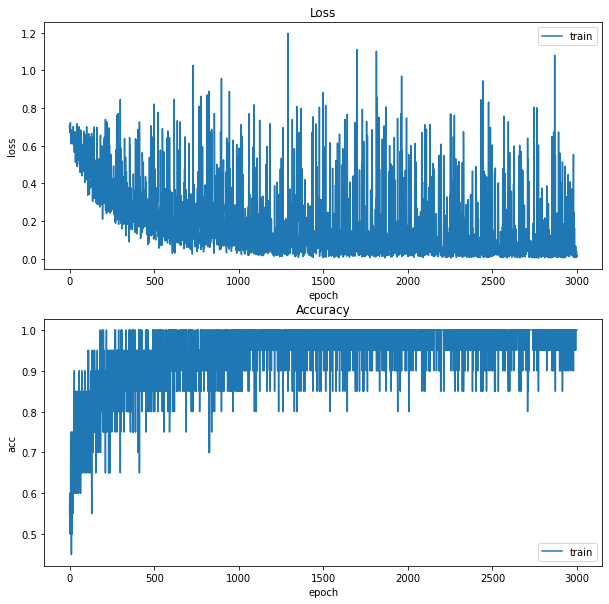

In [20]:
history_to_string(state['history'], suppress_val_data=True)

In [ ]:
# Hyperparameter search
### right now, I'm thinking that if I increase my batch size, that could stop the oscillating!
#------------------FACTORS TO CONSIDER------------------
# 1. Dataset size
#       list(11, 25, 100, len(df))
# 2. Number of hidden units
#       ??????????
# 3. Number of epochs
#       list(1, 10, 100, 1000)
# 4. Batch size
#       list(1, 10, 16, 32)
# 5. Learning rate
#       list(0.001, 0.001, 0.01, 0.1, 1)
# 6. Dropout rate
# 7. Loss function
# 8. Optimizer
# 9. Whether to use linear or cosine annealing

# for ds_size in [1000, len(df)]:
for ds_size in [11, 25, 100, 2432]:
    for num_epochs in [2, 10, 100, 3000]:
        for lr in [0.0001, 0.001, 0.01, 0.1]:
            pass

0628-1708_DSsize-11_epochs-100_lr-0.01 	 <class 'dict'> 	 epoch: 100	 curr_lr: -1.4281657142856943e-05


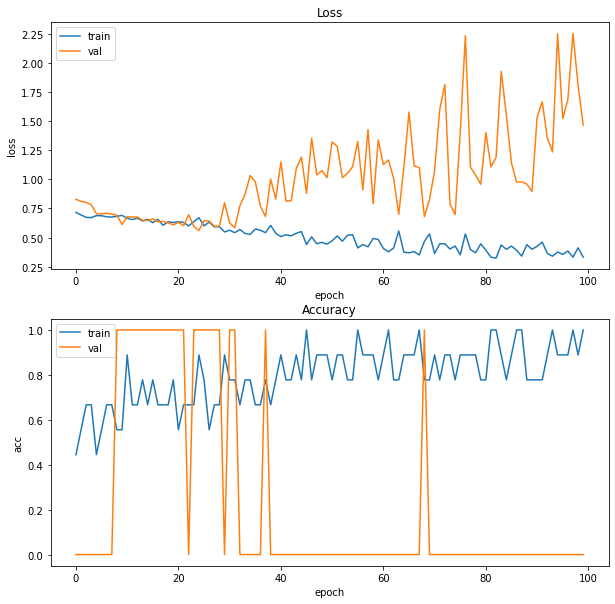

0628-1715_DSsize-11_epochs-3000_lr-0.01 	 <class 'dict'> 	 epoch: 3000	 curr_lr: -4.7218857142849666e-07


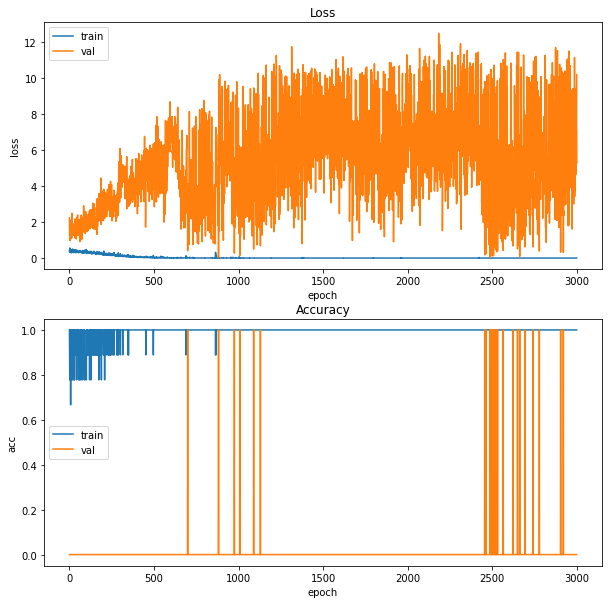

0629-1419_DSsize-25_epochs-100_lr-0.01 	 <class 'dict'> 	 epoch: 100	 curr_lr: -7.138828571428548e-06


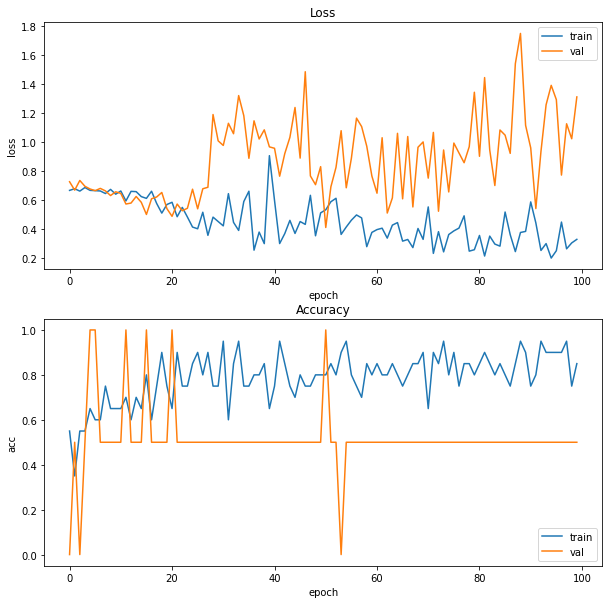

0629-1422_DSsize-25_epochs-3000_lr-0.01 	 <class 'dict'> 	 epoch: 3000	 curr_lr: -2.3409428571421684e-07


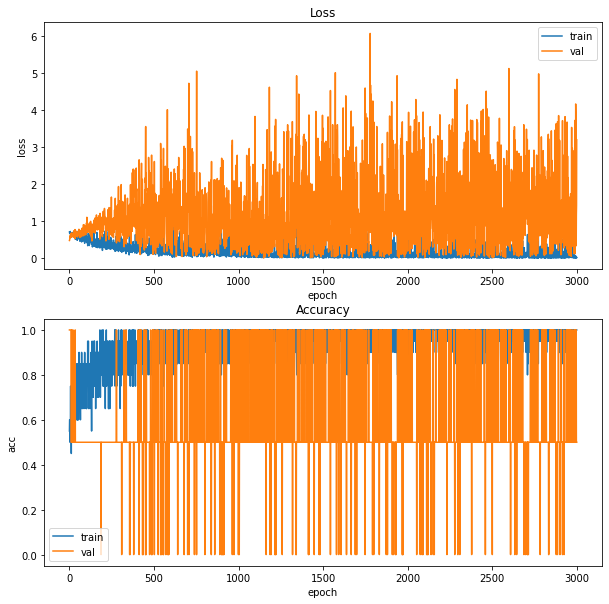

0629-1604_DSsize-2432_epochs-100_lr-0.01 	 <class 'dict'> 	 epoch: 100	 curr_lr: -1.130955503512044e-07


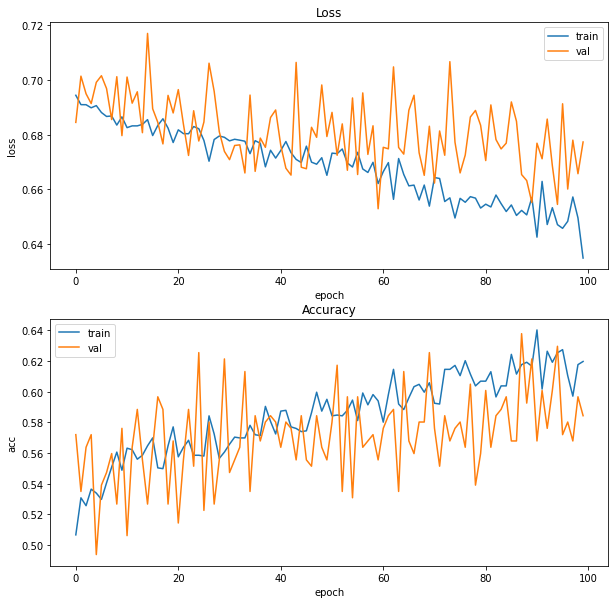

0629-2147_DSsize-198_epochs-100_lr-0.01 	 <class 'dict'> 	 epoch: 100	 curr_lr: -1.424565714285616e-06


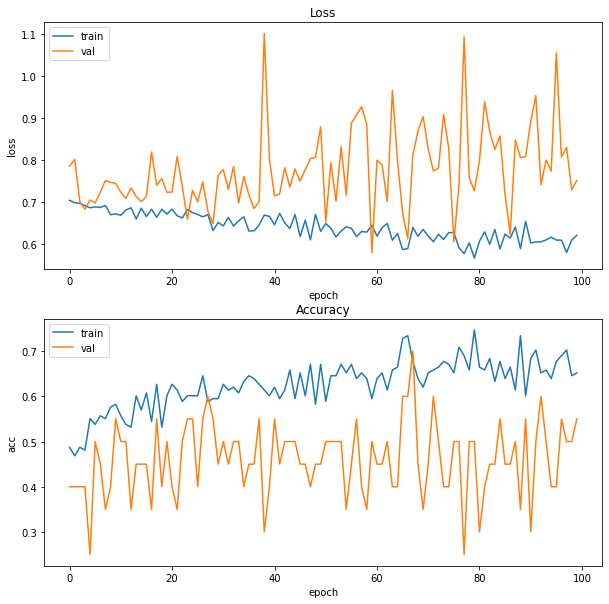

In [33]:
# Print record of previous models and training history
for file in os.listdir('models'):
    temp_state = torch.load(f'models/{file}', map_location=device)
    print(file, '\t', type(temp_state), '\t', f"epoch: {temp_state['epoch']}\t curr_lr: {temp_state['optimizer']['param_groups'][0]['lr']}")
    history_to_string(temp_state['history'])

#### Run inference on final test set

In [ ]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, test_dl):
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
        for data in test_dl:
          # Get the input features and target labels, and put them on the GPU
          inputs, labels = data[0].to(device), data[1].to(device)

          # Normalize the inputs
          inputs_m, inputs_s = inputs.mean(), inputs.std()
          inputs = (inputs - inputs_m) / inputs_s

          # Get predictions
          outputs = model(inputs)

          # Get the predicted class with the highest score
          _, prediction = torch.max(outputs,1)
          # Count of predictions that matched the target label
          correct_prediction += (prediction == labels).sum().item()
          total_prediction += prediction.shape[0]
      
    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, test_dl)

In [ ]:
# # ----------------------------
# # Old Training Loop, basically from the tutorial
# # ----------------------------
# def training(model, train_dl, num_epochs, device):
#     # Loss Function, Optimizer and Scheduler
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
#                                                   steps_per_epoch=int(len(train_dl)),
#                                                   epochs=num_epochs,
#                                                   anneal_strategy='linear')


#     # Repeat for each epoch
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         correct_prediction = 0
#         total_prediction = 0

#         # Repeat for each batch in the training set
#         for i, data in enumerate(train_dl):
#             # Get the input features and target labels, and put them on the GPU
#             inputs, labels = data[0].to(device), data[1].to(device)

#             # Normalize the inputs
#             inputs_m, inputs_s = inputs.mean(), inputs.std()
#             inputs = (inputs - inputs_m) / inputs_s

#             # Zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             scheduler.step()

#             # Keep stats for Loss and Accuracy
#             running_loss += loss.item()

#             # Get the predicted class with the highest score
#             _, prediction = torch.max(outputs,1)
#             # Count of predictions that matched the target label
#             correct_prediction += (prediction == labels).sum().item()
#             total_prediction += prediction.shape[0]

#             # if i % 10 == 0:    # print every 10 mini-batches
#             #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
#         # Print stats at the end of the epoch
#         num_batches = len(train_dl)
#         avg_loss = running_loss / num_batches
#         acc = correct_prediction/total_prediction
#         print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

#     print('Finished Training')


# # Create training and validation data loaders
# train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
# val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=True)
# test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=True)

# num_epochs=2   # Just for demo, adjust this higher.
# training(myModel, train_dl, num_epochs, device=device)